In [3]:
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np 
from urllib.request import urlopen as uopen
from urllib.request import Request as request
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.matrix 


---
---
# some initialisations :
---
---

In [4]:
colors = ['Blanc', 'Noir', 'Or', 'Rose',
       'Mesh Rose', 'Black', 'Argent', 'Beige',
       'Kaki','Vert','Bleu', 'Jaune',
       'Rouge', 'Bleu','Gris', 'Bleu Nuit', 'Bleu Pastel', 'Camel',
       'Gold', 'Grenat','Gris Clair','Mauve', 'Multicolore','Bronze',
       'Noir/N', 'Orange','PINK', 'Rose Clair', ' Rose clair',
       'Violet',' Silver', 'Blanche','Marron','Verte']
colors = list(map(lambda x: x.lower().strip(), colors))
colors = np.unique(colors) 

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 '}
df = pd.DataFrame()


---
---
# extarction des donnees:
---
---

In [5]:
def extract(articles, df, gender):
    for article in articles:
        # extract
        full_name = article.find_all("h3", {"class": "name"})[0].text.lower()
        price = article.find_all("div", {"class": "prc"})[0].text
        reduction = article.find_all("div", {"class": "tag _dsct _sm"})
        stars = article.find_all("div", {"class": "stars _s"})

        # reduction / stars TRT
        reduction = reduction[0].text[:-1] if reduction else 0
        stars = stars[0].text.split()[0] if stars else 0

        a= {
        "gender" : gender,
        "description" : full_name,
        "price" : price,
        "stars" : float(stars)/10,
        "reduction": float(reduction)/100
        }
        df = df.append(a, ignore_index=True)

    return df

In [ ]:

for j in range(2):
    gender = "homme" if j  else "femme"
    for i in range(1, 8):
        url = 'https://www.jumia.dz/catalog/?q=basket+'+gender+'&page='+str(i)+'#catalog-listing'
        print(url)
        req = request(url=url, headers=headers) 
        client = uopen(req)
        page_html = client.read()
        client.close()
        parsed = soup(page_html, "html.parser") 
        articles = parsed.find_all("article",{ 'class' :"prd _fb col c-prd"})
        df = extract(articles, df, gender)

In [5]:
df.to_csv("data.csv", index = False)

---
---
#    pretraitement des donnees:
---
---

In [6]:
def brand_trt(full_name):
    if "bask" in full_name:
        return full_name[:full_name.index("bask")].strip()
    elif " chaus" in full_name:
        return full_name[:full_name.index(" chaus")].strip()
    else :
        return "None"

def brand_trt2(x):

    if x == "noennamenull" or x =="fashion" or x =="None":
        return "no name"
    if x == "skechers":
        return "sketchers"
    if x == "asics performance":
        return 'asics'
    if x == "hummel ensemble homme - core" or x == 'hummel core':
        return "hummel"
    else :
        return x

In [7]:
df["brand"] = df["description"].apply(brand_trt)
df = df[df["brand"] != ""]
df["new_brand"] = df["brand"].apply(brand_trt2)

del df["brand"]

In [8]:
def price_trt(price):
    price = price.replace(",", "").replace("DA", "")
    if "-" in price:
        price = price.split("-")
        price = (float(price[0])+ float(price[1]))/2
    return float(price) /1000

In [9]:
df["avg_price"] = df["price"].apply(price_trt)
del df["price"]

In [10]:
def color_trt(full_name):
    color  = "None"
    list_color = list(filter(lambda x: x in colors, full_name.split()))
    if list_color:
        color = reduce(lambda x, a: a+ " "+ x, list_color)
    return color

In [11]:
df["color"] = df["description"].apply(color_trt)

In [12]:
def uni_trt(color):
    return 1 if len(color.split()) == 1 else 0
        
def multi_trt(color):
    return 1 if len(color.split()) != 1 else 0

In [1]:
df["uni"] = df["color"].apply(uni_trt)
# df["multi"] = df["color"].apply(multi_trt)

NameError: name 'df' is not defined

In [14]:
df.to_csv("data_trt.csv", index = False)

---
---
# Analyse des donnees:
---
---


<BarContainer object of 58 artists>

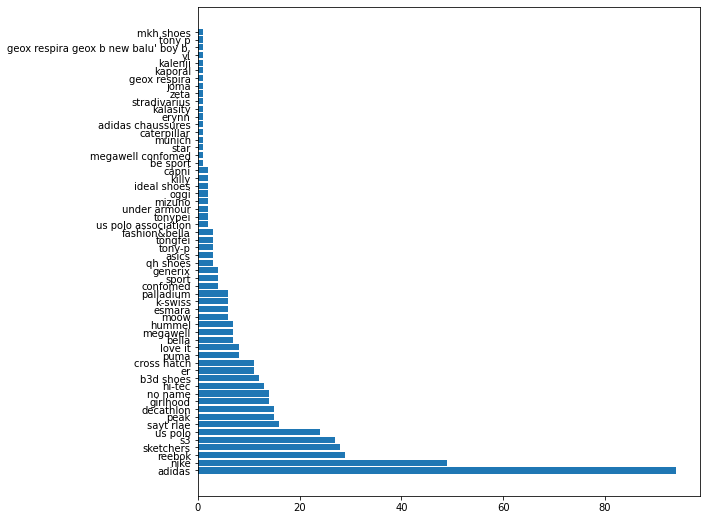

In [17]:
# number of shoes in each brand
brands = list(df["new_brand"].value_counts().index)
values = df["new_brand"].value_counts().values
plt.figure(figsize=(9, 9))
plt.barh(brands, values)

<BarContainer object of 58 artists>

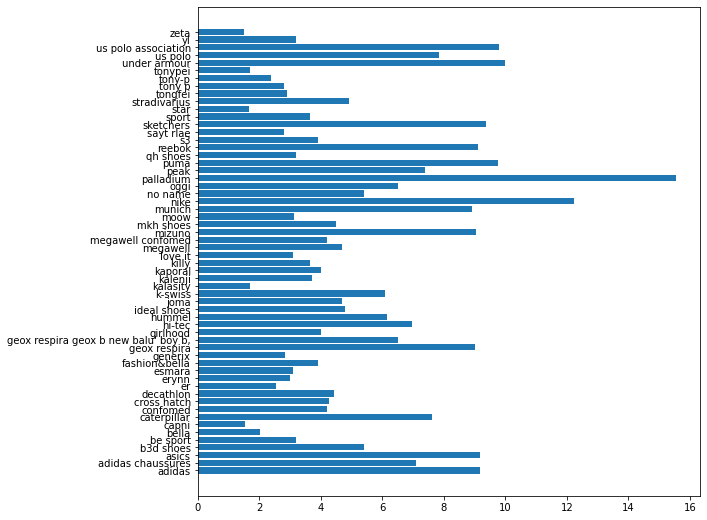

In [18]:
# Avrage price for each brand
brands = np.unique(df["new_brand"].values)
avg_prices = []
for b in brands:
    x = df[df["new_brand"]== b]["avg_price"].values.mean()
    avg_prices.append(x)
plt.figure(figsize=(9, 9))
plt.barh(brands, avg_prices)

***
# convert categorical data to numerical data:
***

In [19]:
new_df = df[ ["gender","reduction"	,"stars","new_brand","avg_price","uni"] ]

In [20]:
new_df = pd.get_dummies(new_df)

In [21]:
new_df

,reduction,stars,avg_price,uni,gender_femme,gender_homme,new_brand_adidas,new_brand_adidas chaussures,new_brand_asics,new_brand_b3d shoes,...,new_brand_stradivarius,new_brand_tongfei,new_brand_tony p,new_brand_tony-p,new_brand_tonypei,new_brand_under armour,new_brand_us polo,new_brand_us polo association,new_brand_yl,new_brand_zeta
1,0.28,0.00,4.200,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.47,0.36,1.599,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.50,0.50,2.990,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.41,0.00,3.500,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.35,0.39,3.200,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.00,0.00,17.900,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
556,0.00,0.00,13.500,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
557,0.24,0.50,10.570,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558,0.29,0.47,5.500,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
---
# buid the model:
---
---

In [22]:
y = new_df["avg_price"]
X = new_df.drop("avg_price", axis = 1)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
multi_reg =  LinearRegression()
multi_reg.fit(X_train, y_train)
multi_pred = multi_reg.predict(X_test)
print(multi_reg.score(X_test, y_test))


-1.6181453841988893e+23
